# Experiments on MotionSense Resampled to 30Hz

This notebook will perform basic experiments on the balanced MotionSense dataset with the following steps:
1. Quick load train, test and validation CSV subsets from the balanced MotionSense dataset using `PandasDatasetsIO` helper
2. Subclassing the `Dataset` interface using `PandasMultiModalDataset`
3. Apply the fourier transform on the dataset
4. Train and evaluate SVM, KNN and Random Forest classification models in the frequency domain, removing high frequencies. Train models by entering range of features (eg 0 to 1Hz, 0 to 2Hz, ..., 0 to 15Hz) and compare performances when adding high frequencies.

The experiments will evaluate the performance of SVM, KNN and RF models on the balanced MotionSense dataset in both time and frequency domains.

## Common imports and definitions

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("../../..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-09-13 21:55:33.287742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-13 21:55:33.287763: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading data
Change the path to use in other datasets

In [2]:
# Path for MotionSense resampled to 50Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../../../data/views/MotionSense/resampled_view_30Hz")

Once paths is defined, we can load the CSV as pandas dataframes

In [3]:
# MotionSense dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

Lets take a look in the train dataframes

In [4]:
train.head()

,Unnamed: 0,userAcceleration.x-0,userAcceleration.x-1,userAcceleration.x-2,userAcceleration.x-3,userAcceleration.x-4,userAcceleration.x-5,userAcceleration.x-6,userAcceleration.x-7,userAcceleration.x-8,...,rotationRate.z-85,rotationRate.z-86,rotationRate.z-87,rotationRate.z-88,rotationRate.z-89,activity code,length,trial_code,index,user
0,0,-0.186833,-0.179195,-0.226435,-0.234763,-0.267824,-0.234534,-0.235421,-0.133759,-0.297125,...,0.153844,0.456858,0.898804,1.139253,0.275556,0,150,1,150,11
1,1,-0.054442,0.260099,0.022933,0.019339,0.148599,-0.036896,-0.125777,-0.110877,0.016260,...,0.848919,0.559802,0.253026,0.858864,0.799075,0,150,1,900,12
2,2,-0.007696,-0.009515,0.051284,-0.082342,0.046316,0.062557,-0.032338,-0.108787,-0.090480,...,0.789453,0.495270,-0.042529,-0.161110,0.129157,0,150,1,1050,21
3,3,-0.435023,-0.557701,-0.284523,0.142448,0.545683,0.363495,0.006622,-0.042397,-0.412486,...,-1.073667,-0.531939,-0.302297,0.086762,0.600790,0,150,2,150,17
4,4,0.098066,0.398057,0.321284,-0.024039,0.372623,0.302234,0.199685,0.285311,0.319281,...,0.884322,1.476072,1.630557,0.927239,0.672827,0,150,11,450,21


## Creating a Librep dataset from pandas dataframes

Change the features to use in other datasets

In [5]:
# MotionSense features to select
features = [
    "userAcceleration.x",
    "userAcceleration.y",
    "userAcceleration.z",
    "rotationRate.x",
    "rotationRate.y",
    "rotationRate.z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
validation_dataset = PandasMultiModalDataset(
    validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

## Fourier Transform

In [6]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [7]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

### Use FFT in MotionSense

In [8]:
train_dataset_fft = transformer(train_dataset)
validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test_dataset)

In [9]:
train_dataset[:][0]

array([[-0.18683339, -0.17919536, -0.22643513, ...,  0.89880418,
         1.13925318,  0.27555584],
       [-0.05444212,  0.26009924,  0.0229331 , ...,  0.25302617,
         0.85886433,  0.79907488],
       [-0.00769597, -0.00951478,  0.05128415, ..., -0.04252899,
        -0.16110965,  0.12915699],
       ...,
       [ 0.12156633,  0.08784327,  0.22650777, ..., -0.33646327,
         0.188585  , -0.40013492],
       [ 0.30457243,  1.98117781,  1.05075516, ...,  4.15423467,
         3.18971673, -0.32404159],
       [-0.82321128,  0.18495934, -0.01894481, ..., -3.27345907,
        -4.03518556, -2.9964158 ]])

In [10]:
train_dataset_fft[:][0]

array([[ 7.8524508 ,  1.97250947,  0.93442469, ...,  1.89050909,
         0.83709156,  1.20154337],
       [ 0.6293334 ,  2.21672832,  1.13328689, ...,  1.16967075,
         3.53071988,  1.06557213],
       [ 3.1927866 ,  1.55762082,  0.60235897, ...,  0.55560622,
         0.71680657,  0.39816055],
       ...,
       [ 2.13171   ,  0.97741234,  1.88558163, ...,  3.39217532,
         0.16116226,  2.08539881],
       [ 7.3141302 ,  5.07977712,  5.15892564, ...,  3.59260974,
         5.23529476,  4.98941257],
       [12.2992248 ,  2.30543013,  4.6540158 , ...,  4.96081329,
         6.97650088,  4.14331   ]])

## Functions to remove low/high frequencies

In [11]:
def remove_high_frequencies(X, num_windows, num_per_slices, features):

    df_fft = []
    df_fft_y = []

    for sample in X:
        s = np.reshape(sample[0],(num_windows,num_per_slices))
        aux = []
        for x in s:
            aux.append(x[:num_features])
        aux = np.array(aux)
        new_sample = aux.reshape((num_windows*num_features))
        df_fft.append(new_sample)
        df_fft_y.append(sample[1])
    df_fft = np.array(df_fft)
    df_fft_y = np.array(df_fft_y)

    df_fft = pd.DataFrame(df_fft,columns=features)
    df_fft['activity code'] = df_fft_y

    features =[
        'fft.userAcceleration.x',
         'fft.userAcceleration.y',
         'fft.userAcceleration.z',
         'fft.rotationRate.x',
         'fft.rotationRate.y',
         'fft.rotationRate.z'
    ]

    df_fft = PandasMultiModalDataset(
        df_fft,
        feature_prefixes=features,
        label_columns="activity code",
        as_array=True
    )

    return df_fft

combined_train_dset = PandasMultiModalDataset(
    pd.concat([train, validation]),
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)
fs_cut = 15
train_fft = transformer(combined_train_dset)
test_fft = transformer(test_dataset)

num_windows = train_fft.num_windows
num_per_slices = train_fft.window_slices[0][1]
num_per_frequency = num_per_slices // fs_cut

## Train and evaluate Random Forest classifier

In [12]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from librep.metrics.report import ClassificationReport
import yaml

reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':1000} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [13]:
k = 1
results_rf = []
while(k <= fs_cut):
    num_features = num_per_frequency*k

    features = []
    for i in range(num_windows):
        for j in range(num_features):
            features.append(train_fft.window_names[i]+'-{}'.format(j))

    train_fft_reduce = remove_high_frequencies(train_fft, num_windows, num_per_slices, features)
    test_fft_reduce = remove_high_frequencies(test_fft, num_windows, num_per_slices, features)

    result = multi_run_experiment(train_fft_reduce, test_fft_reduce)
    results_rf.append(result)
    print('Iteração: ', k)
    k+=1

Iteração:  1
Iteração:  2
Iteração:  3
Iteração:  4
Iteração:  5
Iteração:  6
Iteração:  7
Iteração:  8
Iteração:  9
Iteração:  10
Iteração:  11
Iteração:  12
Iteração:  13
Iteração:  14
Iteração:  15


In [14]:
train_fft.window_names

['fft.userAcceleration.x',
 'fft.userAcceleration.y',
 'fft.userAcceleration.z',
 'fft.rotationRate.x',
 'fft.rotationRate.y',
 'fft.rotationRate.z']

In [15]:
test_fft_reduce.data.shape

(1020, 271)

## Train and evaluate Support Vector Machine classifier

In [16]:
#from librep.estimators import SVC
from sklearn.svm import SVC

experiment = SimpleTrainEvalWorkflow(estimator=SVC, estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

k = 1
results_svc = []
while(k <= fs_cut):
    num_features = num_per_frequency*k

    features = []
    for i in range(num_windows):
        for j in range(num_features):
            features.append(train_fft.window_names[i]+'-{}'.format(j))

    train_fft_reduce = remove_high_frequencies(train_fft, num_windows, num_per_slices, features)
    test_fft_reduce = remove_high_frequencies(test_fft, num_windows, num_per_slices, features)

    result = multi_run_experiment(train_fft_reduce, test_fft_reduce)
    results_svc.append(result)
    print('Iteração: ', k)
    k+=1

Iteração:  1
Iteração:  2
Iteração:  3
Iteração:  4
Iteração:  5
Iteração:  6
Iteração:  7
Iteração:  8
Iteração:  9
Iteração:  10
Iteração:  11
Iteração:  12
Iteração:  13
Iteração:  14
Iteração:  15


## Train and evaluate K Neighbors Classifier classifier

In [17]:
#from librep.estimators import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

experiment = SimpleTrainEvalWorkflow(estimator=KNeighborsClassifier, estimator_creation_kwags ={'n_neighbors' :1} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

k = 1
results_knn = []
while(k <= fs_cut):
    num_features = num_per_frequency*k

    features = []
    for i in range(num_windows):
        for j in range(num_features):
            features.append(train_fft.window_names[i]+'-{}'.format(j))

    train_fft_reduce = remove_high_frequencies(train_fft, num_windows, num_per_slices, features)
    test_fft_reduce = remove_high_frequencies(test_fft, num_windows, num_per_slices, features)

    result = multi_run_experiment(train_fft_reduce, test_fft_reduce)
    results_knn.append(result)
    print('Iteração: ', k)
    k+=1

Iteração:  1
Iteração:  2
Iteração:  3
Iteração:  4
Iteração:  5
Iteração:  6
Iteração:  7
Iteração:  8
Iteração:  9
Iteração:  10
Iteração:  11
Iteração:  12
Iteração:  13
Iteração:  14
Iteração:  15


In [18]:
def chart(classifiers, metric, xlabel, title):
    X = np.arange(1, fs_cut+1, 1)
    for classifier in classifiers:
        plt.plot(X, classifiers[classifier][metric], label=classifier) 

    plt.xlabel(xlabel) 
    plt.ylabel(metric) 
    plt.title(title) 
    plt.xlim(1,fs_cut)
    plt.legend() 
    plt.grid()
    plt.show()

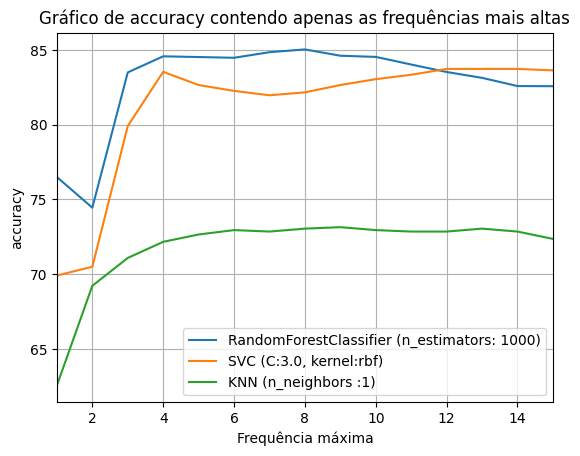

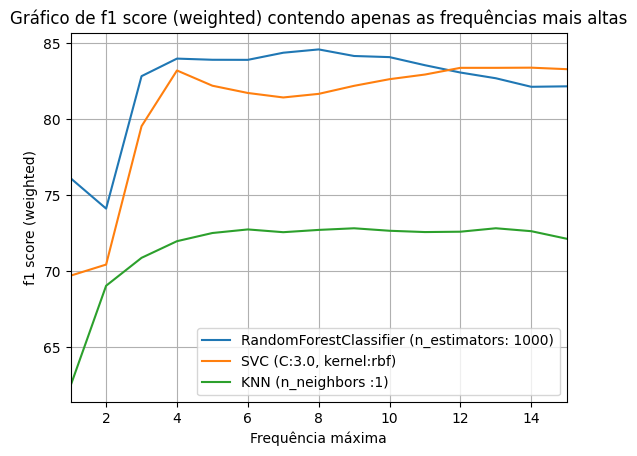

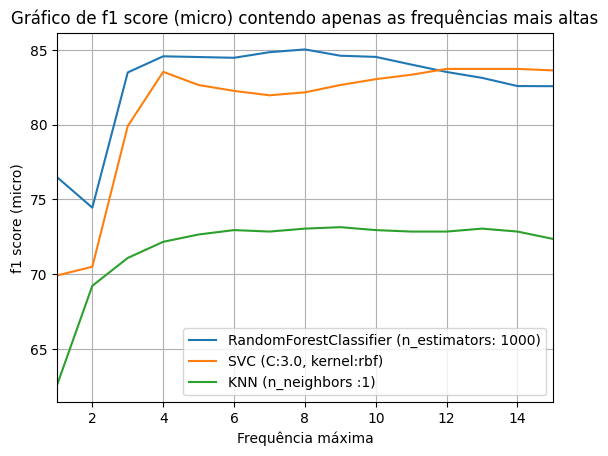

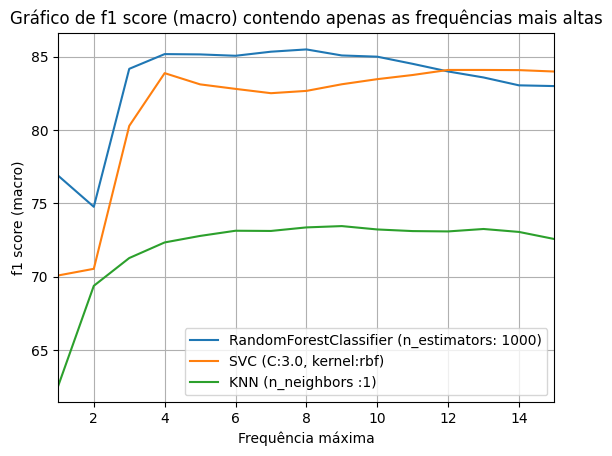

In [19]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'f1 score (weighted)', 'f1 score (micro)', 'f1 score (macro)']

scores_rf = {metric:[] for metric in metrics}
scores_rf_average = {metric:[] for metric in metrics}

scores_svc = {metric:[] for metric in metrics}
scores_svc_average = {metric:[] for metric in metrics}

scores_knn = {metric:[] for metric in metrics}
scores_knn_average = {metric:[] for metric in metrics}

for metric in metrics:
    for i in range(fs_cut):
            score_rf, score_svc, score_knn = [], [], []
            for j in range(10):
                value_rf = results_rf[i]['runs'][j]['result'][0][metric]
                score_rf.append(100*value_rf)

                value_svc = results_svc[i]['runs'][j]['result'][0][metric]
                score_svc.append(100*value_svc)

                value_knn = results_knn[i]['runs'][j]['result'][0][metric]
                score_knn.append(100*value_knn)

            scores_rf[metric].append(score_rf)
            scores_rf_average[metric].append(np.mean(score_rf))

            scores_svc[metric].append(score_svc)
            scores_svc_average[metric].append(np.mean(score_svc))

            scores_knn[metric].append(score_knn)
            scores_knn_average[metric].append(np.mean(score_knn))

classifiers = {
    'RandomForestClassifier (n_estimators: 1000)' : scores_rf_average,
    'SVC (C:3.0, kernel:rbf)' : scores_svc_average,
    'KNN (n_neighbors :1)' : scores_knn_average
}
for metric in metrics:
    xlabel = "Frequência máxima"
    # ylabel = metric
    title = "Gráfico de {} contendo apenas as frequências mais altas".format(metric)
    chart(classifiers, metric, xlabel, title)